# Filter questions for content
Let's take the NYT questions and filter them to only include questions that have at least one NE overlap with the article text.

This is really what we are interested in learning to generate: can we predict a person's inquiry into a person/place/organization mentioned by the article?

In [1]:
## load sample of data
import pandas as pd
article_question_data = pd.read_csv('../../data/nyt_comments/April2018_article_question_data.tsv', sep='\t', index_col=False)
article_question_data.drop_duplicates(['article_id', 'commentBody', 'userID'], inplace=True)
print(f'{article_question_data.shape[0]} questions')
display(article_question_data.head())

22455 questions


,id,title,authors,text,article_id,approveDate,commentBody,commentType,parentID,userID,userLocation,userDisplayName,comment_question,question_tokens,article_tokens,publisher,dummy_comment_id,article_question_bleu
0,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523409493,If he fires him. People take to the streets. Y...,comment,0.0,84914731.0,Huntsville Al,Sean,You think you got chaos now?,"['You', 'think', 'you', 'got', 'chaos', 'now',...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,0,0.001756
1,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523409425,I've noticed comments stating that somehow thi...,comment,0.0,40747629.0,Aspen,Mark,"<br/><br/>If trump were innocent, in any case,...","['<', 'br', '/><', 'br', '/>', 'If', 'trump', ...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,1,0.004098
2,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523409397,Why have we never seen Trump's tax returns? Fi...,comment,0.0,68845522.0,"Austin, TX",Allison,Why have we never seen Trump's tax returns?,"['Why', 'have', 'we', 'never', 'seen', 'Trump'...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,2,0.003513
4,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523409394,"In the Vanity Fair 2017 interview, Mr. Cohen p...",comment,0.0,79106752.0,TX,Ada,How does anyone with this much skeleton in bot...,"['How', 'does', 'anyone', 'with', 'this', 'muc...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,4,0.007026
5,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523407457,Did any of the Trump/Cohen apologists actually...,comment,0.0,24038912.0,Narnia,Maxie,Did any of the Trump/Cohen apologists actually...,"['Did', 'any', 'of', 'the', 'Trump', '/', 'Coh...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,5,0.002927


In [2]:
unique_article_data = article_question_data.loc[:, ['text', 'article_id']].drop_duplicates('article_id')
print('%d unique articles to parse'%(unique_article_data.shape[0]))

396 unique articles to parse


In [4]:
## specify GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import stanza
nlp_pipeline = stanza.Pipeline(lang='en', processors='tokenize,ner', use_gpu=True)
test_sent = 'I voted for Donald Trump this year.'
test_output = nlp_pipeline(test_sent)
print(test_output)

2021-01-25 15:45:17 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2021-01-25 15:45:17 INFO: Use device: gpu
2021-01-25 15:45:17 INFO: Loading: tokenize
2021-01-25 15:45:22 INFO: Loading: ner
2021-01-25 15:45:23 INFO: Done loading processors!


[
  [
    {
      "id": 1,
      "text": "I",
      "misc": "start_char=0|end_char=1",
      "ner": "O"
    },
    {
      "id": 2,
      "text": "voted",
      "misc": "start_char=2|end_char=7",
      "ner": "O"
    },
    {
      "id": 3,
      "text": "for",
      "misc": "start_char=8|end_char=11",
      "ner": "O"
    },
    {
      "id": 4,
      "text": "Donald",
      "misc": "start_char=12|end_char=18",
      "ner": "B-PERSON"
    },
    {
      "id": 5,
      "text": "Trump",
      "misc": "start_char=19|end_char=24",
      "ner": "E-PERSON"
    },
    {
      "id": 6,
      "text": "this",
      "misc": "start_char=25|end_char=29",
      "ner": "B-DATE"
    },
    {
      "id": 7,
      "text": "year",
      "misc": "start_char=30|end_char=34",
      "ner": "E-DATE"
    },
    {
      "id": 8,
      "text": ".",
      "misc": "start_char=34|end_char=35",
      "ner": "O"
    }
  ]
]


In [5]:
def extract_all_named_entities(text, pipeline, valid_NE_types=['PERSON', 'GPE', 'ORG', 'EVENT']):
    text_doc = pipeline(text)
    named_entities = []
    for text_sent_i in text_doc.sentences:
        NE_tokens_i = []
        for token_j in text_sent_i.tokens:
            token_j_NE = token_j.ner
            token_j_NE_type = token_j_NE.split('-')[-1]
            if(token_j_NE != 'O' and token_j_NE_type in valid_NE_types):
                token_j_text = token_j.text
                # "END" or "SINGLE" token => pop from queue
                if(token_j_NE.startswith('E') or token_j_NE.startswith('S')):
                    NE_tokens_i.append(token_j_text)
                    NE_final = '_'.join(NE_tokens_i)
                    named_entities.append(NE_final)
                    NE_tokens_i = []
                else:
                    NE_tokens_i.append(token_j_text)
    return named_entities

In [6]:
test_sent = 'I voted for Trump this year.'
test_NEs = extract_all_named_entities(test_sent, nlp_pipeline)
print(test_NEs)

['Trump']


In [7]:
from tqdm import tqdm
tqdm.pandas()
valid_NE_types = {'PERSON', 'GPE', 'ORG', 'EVENT'}
unique_article_data = unique_article_data.assign(**{
    'text_NE' : unique_article_data.loc[:, 'text'].progress_apply(lambda x: extract_all_named_entities(x, nlp_pipeline, valid_NE_types=valid_NE_types))
})

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 396/396 [05:19<00:00,  1.24it/s]


In [8]:
## get most frequent NEs
unique_article_NE_counts = pd.Series([y for x in unique_article_data.loc[:, 'text_NE'].values for y in x]).value_counts()
display(unique_article_NE_counts.head(10))

Trump                1406
Facebook              412
the_United_States     282
Russia                265
Syria                 261
Pruitt                254
Comey                 246
China                 185
Cohen                 166
New_York              161
dtype: int64

Great! These NEs make sense given the context of the news (April 2018).

In [12]:
## comment NEs
# use GPU because runtime
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# reload pipeline
import stanza
nlp_pipeline = stanza.Pipeline(lang='en', processors='tokenize,ner', use_gpu=True)
valid_NE_types = {'PERSON', 'GPE', 'ORG', 'EVENT'}
article_question_data = article_question_data.assign(**{
    'question_NE' : article_question_data.loc[:, 'comment_question'].progress_apply(lambda x: extract_all_named_entities(x, nlp_pipeline, valid_NE_types=valid_NE_types))
})

2021-01-25 17:33:55 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2021-01-25 17:33:55 INFO: Use device: gpu
2021-01-25 17:33:55 INFO: Loading: tokenize
2021-01-25 17:33:55 INFO: Loading: ner
2021-01-25 17:33:56 INFO: Done loading processors!
100%|██████████| 22455/22455 [10:33<00:00, 35.45it/s]


In [13]:
## get most frequent NEs
unique_question_NE_counts = pd.Series([y for x in article_question_data.loc[:, 'question_NE'].values for y in x]).value_counts()
display(unique_question_NE_counts.head(20))

Trump           2538
Comey            426
US               367
Cohen            326
Syria            312
Mueller          287
Russia           265
FBI              232
Assad            217
America          215
Ryan             213
Obama            208
GOP              191
Congress         190
Clinton          148
Putin            139
Facebook         137
Hillary          129
Donald_Trump     128
Pruitt           125
dtype: int64

Great! These NEs are not completely disjoint from the NEs that we saw before.

How many comments share at least one NE with the article in question?

In [15]:
article_NE_data = pd.merge(unique_article_data.loc[:, ['article_id', 'text_NE']], article_question_data.loc[:, ['question_NE', 'article_id', 'commentType', 'userID']], how='inner')
print(article_NE_data.shape[0])
# compute overlap
article_NE_data = article_NE_data.assign(**{
    'text_question_NE' : article_NE_data.apply(lambda x: set(x.loc['text_NE']) & set(x.loc['question_NE']), axis=1)
})
display(article_NE_data.head())

22455


,article_id,text_NE,question_NE,commentType,userID,text_question_NE
0,5acbc4e2068401528a2a5a2c,"[WASHINGTON, F.B.I., Rockefeller_Center, Trump...",[],comment,84914731.0,{}
1,5acbc4e2068401528a2a5a2c,"[WASHINGTON, F.B.I., Rockefeller_Center, Trump...",[],comment,40747629.0,{}
2,5acbc4e2068401528a2a5a2c,"[WASHINGTON, F.B.I., Rockefeller_Center, Trump...",[Trump],comment,68845522.0,{Trump}
3,5acbc4e2068401528a2a5a2c,"[WASHINGTON, F.B.I., Rockefeller_Center, Trump...",[],comment,79106752.0,{}
4,5acbc4e2068401528a2a5a2c,"[WASHINGTON, F.B.I., Rockefeller_Center, Trump...","[Trump, Cohen]",comment,24038912.0,"{Cohen, Trump}"


In [20]:
NE_overlap_question_count = (article_NE_data.loc[:, "text_question_NE"].apply(lambda x: len(x) > 0)).sum()
print(f'{NE_overlap_question_count / article_NE_data.shape[0] * 100}% of questions ({NE_overlap_question_count}/{article_NE_data.shape[0]}) mention a relevant NE')

23.522600757069696% of questions (5282/22455) mention a relevant NE


Great! About 1/4 of questions mention a relevant NE.

What are the overlap entities?

In [21]:
overlap_NE_counts = pd.Series([y for x in article_NE_data.loc[:, 'text_question_NE'].values for y in x]).value_counts()
display(overlap_NE_counts.head(20))

Trump                2183
Comey                 369
Syria                 262
Cohen                 214
Mueller               214
Russia                202
Assad                 179
Ryan                  129
Facebook              119
Pruitt                108
America                99
Congress               92
Israel                 77
Giuliani               72
Iran                   71
Obama                  68
Clinton                65
Putin                  62
China                  56
the_United_States      54
dtype: int64

Not surprisingly, most of the questions address important politicians and geopolitical entities (including "Facebook").

Is the distribution of "relevant questions" skewed toward particular articles?

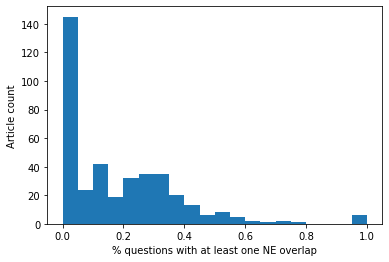

In [24]:
NE_overlap_pct_per_article = article_NE_data.groupby('article_id').apply(lambda x: x[x.loc[:, 'text_question_NE'].apply(lambda y: len(y)) > 0].shape[0] / x.shape[0])
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(NE_overlap_pct_per_article, bins=20)
plt.xlabel('% questions with at least one NE overlap')
plt.ylabel('Article count')
plt.show()

Skewed distribution! About half the articles have few/no questions with relevant NEs.

After re-training the model on just questions with NE overlap, how do the generated questions look?

In [32]:
## load model
from transformers import AutoModelForSeq2SeqLM, BartTokenizer
import torch
# model = AutoModelForSeq2SeqLM.from_pretrained('allenai/led-base-16384', cache_dir='../../data/longformer_cache/')
tokenizer = torch.load('../../data/nyt_comments/LongFormer_tokenizer.pt')
model.resize_token_embeddings(len(tokenizer))
model_file = '../../data/nyt_comments/NE_overlap/longformer_model/question_generation_model/checkpoint-27500/pytorch_model.bin'
model_state = torch.load(model_file)
model.load_state_dict(model_state)

<All keys matched successfully>

In [33]:
NE_overlap_test_data_file = '../../data/nyt_comments/author_type_NE_overlap_NYT_long_input_val_data.pt'
NE_overlap_test_data = torch.load(NE_overlap_test_data_file)['train']
print(len(NE_overlap_test_data))

6342


In [72]:
## generate questions for example input
# first: sample equal number of questions per article: 10 articles, 10 questions
import numpy as np
np.random.seed(123)
sample_size = 100
article_sample_size = 10
questions_per_article = int(sample_size / article_sample_size)
NE_overlap_test_data_article_ids = np.array(NE_overlap_test_data['article_id'])
sample_article_ids = np.random.choice(NE_overlap_test_data_article_ids, article_sample_size, replace=False)
NE_overlap_test_data_idx = list(range(len(NE_overlap_test_data)))
sample_question_idx = []
for article_id_i in sample_article_ids:
    question_idx_i = np.where(NE_overlap_test_data_article_ids==article_id_i)[0]
    sample_question_idx_i = np.random.choice(question_idx_i, questions_per_article, replace=False)
    sample_question_idx += list(sample_question_idx_i)
sample_NE_overlap_test_data = NE_overlap_test_data.select(sample_question_idx)
from tqdm import tqdm
num_beams = 8
temperature = 1.0
sample_size = 100
NE_overlap_test_data_output = []
max_target_length = 64
for i in tqdm(range(sample_size)):
    output_i = model.generate(input_ids=torch.LongTensor(sample_NE_overlap_test_data['source_ids'][i]).reshape(1,-1), 
                              attention_mask=torch.LongTensor(sample_NE_overlap_test_data['attention_mask'][i]).reshape(1,-1),
                              num_beams=num_beams, temperature=temperature, max_length=max_target_length)
    NE_overlap_test_data_output.append(output_i)

100%|██████████| 100/100 [08:16<00:00,  4.97s/it]


In [73]:
import re
author_token_matcher = re.compile('<[A-Z_0-9]+>$')
for i, (test_data_i, output_i) in enumerate(zip(sample_NE_overlap_test_data, NE_overlap_test_data_output)):
    input_text_i = tokenizer.decode(test_data_i['source_ids'], skip_special_tokens=True)
    target_text_i = tokenizer.decode(test_data_i['target_ids'], skip_special_tokens=True)
    output_text_i = tokenizer.decode(output_i.tolist()[0], skip_special_tokens=True)
    author_token_i = 'N/A'
    author_token_match_i = author_token_matcher.search(input_text_i)
    if(author_token_match_i is not None):
        author_token_i = author_token_match_i.group(0)
    print(f'question {i}')
    print(f'source text = {input_text_i[:300]}...{author_token_i}')
    print(f'\ttarget question = {target_text_i}')
    print(f'\tpredicted question = {output_text_i}')

question 0
source text =  -- The United States and European allies launched airstrikes on Friday night against Syrian research, storage and military targets as President Trump sought to punish President Bashar al-Assad for a suspected chemical attack near Damascus last weekend that killed more than 40 people. Britain and Fr...<COMMENT_LEN_1_AUTHOR>
	target question = Recall the Senate vote on whether the US should attack Iraq?
	predicted question = Why does the US have the right to get involved in another country ’ s politics?
question 1
source text =  -- The United States and European allies launched airstrikes on Friday night against Syrian research, storage and military targets as President Trump sought to punish President Bashar al-Assad for a suspected chemical attack near Damascus last weekend that killed more than 40 people. Britain and Fr...<NONUS_AUTHOR>
	target question = Hundreds of thousands have died and suddenly one attack is enough to provoke airstrikes by the US?
	predi

question 15
source text =  -- Paul D. Ryan took the helm of the House two and a half years ago, not because he wanted it, but because he was seen as the only lawmaker who could keep Republicans from devouring themselves. They had shut down the government, nearly precipitated a debt crisis and toppled a speaker, John A. Boehn...<COMMENT_COUNT_0_AUTHOR>
	target question = Not in all the hateful speech and all the lies and all the corruption he's passively accepted from Trump?
	predicted question = The" courage and tenacity of Devin Nunes"?
question 16
source text =  -- Paul D. Ryan took the helm of the House two and a half years ago, not because he wanted it, but because he was seen as the only lawmaker who could keep Republicans from devouring themselves. They had shut down the government, nearly precipitated a debt crisis and toppled a speaker, John A. Boehn...<COMMENT_LEN_0_AUTHOR>
	target question = Does anybody think that Ryan could be preparing to challenge Trump for the party's no

question 31
source text =  Comey is about to be ubiquitous. His book will be published next week, and parts may leak this week. Starting Sunday, he will begin an epic publicity tour, including interviews with Stephen Colbert, David Remnick, Rachel Maddow, Mike Allen, George Stephanopoulos and" The View." All of which will ra...<US_AUTHOR>
	target question = How could a principled public servant in the run-up to the election go public with Clinton's email issues while staying silent about Trumps' Russian connections?
	predicted question = Does he not see the jaw-dropping irony that concealing Hillary's emails might delegitimize her, but not concealing the investigation of Russian interference to elect Trump?
question 32
source text =  Comey is about to be ubiquitous. His book will be published next week, and parts may leak this week. Starting Sunday, he will begin an epic publicity tour, including interviews with Stephen Colbert, David Remnick, Rachel Maddow, Mike Allen, George Stephano

question 47
source text =  -- The United States and European allies launched airstrikes on Friday night against Syrian research, storage and military targets as President Trump sought to punish President Bashar al-Assad for a suspected chemical attack near Damascus last weekend that killed more than 40 people. Britain and Fr...<COMMENT_COUNT_1_AUTHOR>
	target question = Question to ponder : What if Assad had used Chemical Weapons on ISIS?
	predicted question = Why does the US have the right to get involved in another country ’ s politics?
question 48
source text =  -- The United States and European allies launched airstrikes on Friday night against Syrian research, storage and military targets as President Trump sought to punish President Bashar al-Assad for a suspected chemical attack near Damascus last weekend that killed more than 40 people. Britain and Fr...<US_AUTHOR>
	target question = Did he absolutely wink, wink, nod, nod, make sure Putin knew where, when, how the attack was co

question 63
source text =  wife's ultrasound turned up something abnormal in the baby's heart -- an otherwise innocuous feature that correlates with genetic conditions such as Down syndrome. A series of tests confirmed that our son indeed had Down syndrome. We were given the option of abortion, but my wife, Jan, already rega...<US_AUTHOR>
	target question = What happens to children with Down syndrome when their parents pass away, either when the children are young or when they are adults?
	predicted question = And what, pray tell, shall we label the children who have Down syndrome?
question 64
source text =  wife's ultrasound turned up something abnormal in the baby's heart -- an otherwise innocuous feature that correlates with genetic conditions such as Down syndrome. A series of tests confirmed that our son indeed had Down syndrome. We were given the option of abortion, but my wife, Jan, already rega...<COMMENT_LEN_1_AUTHOR>
	target question = What happens to children with Down syndr

question 79
source text =  long after she joined Richard Meier's architecture firm in 1989, Karin Bruckner was working at the office one Sunday, she said, when Mr. Meier came up beside her at a copy machine and started rubbing his body up and down against hers." I just stood there and froze," Ms. Bruckner said."' This is not...<COMMENT_COUNT_0_AUTHOR>
	target question = Yes, he voiced regrets for not speaking up, but realistically, what was he supposed to say to his boss, Richard Meier?
	predicted question = What does Meier have to lose?
question 80
source text =  -- If there was any chance that President Trump and James B. Comey could have avoided all-out war, it ended Sunday night. That was when ABC News aired an interview with Mr. Comey, the president's fired F. B. I. director, as he uses a publicity blitz for his searing tell-all memoir," A Higher Loyalt...<US_AUTHOR>
	target question = What about the Trump ’ s 15 month assault against our Constitution, rule of law, citizens, allie

question 94
source text =  federal judge in Manhattan indicated on Monday that she was not prepared to grant President Trump exclusive first access to documents seized in F. B. I. raids on the office of his personal lawyer, and said that she was considering appointing an independent lawyer to assist in reviewing the seized m...<COMMENT_COUNT_0_AUTHOR>
	target question = How will their determination of privilege be any different from what Trump's lawyers would claim?
	predicted question = How is it that we as a people have allowed an organization like Fox to be able to become the US version of Pravda?
question 95
source text =  federal judge in Manhattan indicated on Monday that she was not prepared to grant President Trump exclusive first access to documents seized in F. B. I. raids on the office of his personal lawyer, and said that she was considering appointing an independent lawyer to assist in reviewing the seized m...<COMMENT_COUNT_1_AUTHOR>
	target question = Why do we care abou

### Find block quotes
Another way for people to engage with the article is to use quotes.

How many comments use such quotes?

In [1]:
## load sample of data
import pandas as pd
article_question_data = pd.read_csv('../../data/nyt_comments/April2018_article_question_data.tsv', sep='\t', index_col=False)
article_question_data.drop_duplicates(['article_id', 'commentBody', 'userID'], inplace=True)
print(f'{article_question_data.shape[0]} questions')
display(article_question_data.head())

22455 questions


,id,title,authors,text,article_id,approveDate,commentBody,commentType,parentID,userID,userLocation,userDisplayName,comment_question,question_tokens,article_tokens,publisher,dummy_comment_id,article_question_bleu
0,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523409493,If he fires him. People take to the streets. Y...,comment,0.0,84914731.0,Huntsville Al,Sean,You think you got chaos now?,"['You', 'think', 'you', 'got', 'chaos', 'now',...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,0,0.001756
1,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523409425,I've noticed comments stating that somehow thi...,comment,0.0,40747629.0,Aspen,Mark,"<br/><br/>If trump were innocent, in any case,...","['<', 'br', '/><', 'br', '/>', 'If', 'trump', ...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,1,0.004098
2,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523409397,Why have we never seen Trump's tax returns? Fi...,comment,0.0,68845522.0,"Austin, TX",Allison,Why have we never seen Trump's tax returns?,"['Why', 'have', 'we', 'never', 'seen', 'Trump'...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,2,0.003513
4,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523409394,"In the Vanity Fair 2017 interview, Mr. Cohen p...",comment,0.0,79106752.0,TX,Ada,How does anyone with this much skeleton in bot...,"['How', 'does', 'anyone', 'with', 'this', 'muc...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,4,0.007026
5,E12122A8E40142EDPQ,Scrutiny for Trump's Allies As Trail of Money ...,"['Apuzzo, Matt']",WASHINGTON -- The F.B.I. raided the Rockefelle...,5acbc4e2068401528a2a5a2c,1523407457,Did any of the Trump/Cohen apologists actually...,comment,0.0,24038912.0,Narnia,Maxie,Did any of the Trump/Cohen apologists actually...,"['Did', 'any', 'of', 'the', 'Trump', '/', 'Coh...","['WASHINGTON', '--', 'The', 'F', '.', 'B', '.'...",NYT,5,0.002927


In [12]:
import re
html_matcher = re.compile('<[^>]+>')
article_question_data = article_question_data.assign(**{
    'contains_HTML' : article_question_data.loc[:, 'commentBody'].apply(lambda x: html_matcher.search(x) is not None)
})
HTML_data = article_question_data[article_question_data.loc[:, 'contains_HTML']]
print('%d/%d questions with HTML'%(HTML_data.shape[0], article_question_data.shape[0]))

8630/22455 questions with HTML


In [13]:
print(HTML_data.loc[:, 'commentBody'].values[50:75])

['Disrespect for the rule of law has been encouraged by Fox News for years now.  The result is apparent in several of the comments posted here.  <br/><br/>In a death\'s-door interview with Melvyn Bragg some twenty-four years ago, Dennis Potter, the great British television dramatist, said, while sipping from a flask of liquid morphine to soothe the pain of pancreatic cancer, that if there was one person he\'d like to kill before he died, it would Rupert Murdoch.  He said that Murdoch had done more to pollute civic discourse in Britain than any other person and that British media and society in general had suffered immeasurably as the result of his depredations.  This was shortly before Murdoch jumped the pond and began to befoul the United States with his lucrative brand of nativist nonsense.  <br/><br/>But it\'s worse than nonsense.  Fox\'s hate-mongering is extremely dangerous.  What Murdoch and Ailes have wrought is anathema to the democratic experiment that is America.  You think I

OK! It seems like most of the fHTML use is just for page-breaks, rather than quoting.

In [14]:
HTML_tags = HTML_data.loc[:, 'commentBody'].apply(lambda x: html_matcher.findall(x))
HTML_tag_counts = pd.Series([y for x in HTML_tags.values for y in x]).value_counts()
display(HTML_tag_counts.head(20))

<br/>                                                                                                                                                                                                                                                                                                                                               37360
</a>                                                                                                                                                                                                                                                                                                                                                  308
<a href="https://tinyurl.com/yb86pcpg" title="https://tinyurl.com/yb86pcpg" target="_blank">                                                                                                                                                                                                                        

In [18]:
quote_matcher = re.compile('(?<=")[^"]+(?=")')
article_question_data = article_question_data.assign(**{
    'contains_quote' : article_question_data.loc[:, 'commentBody'].apply(lambda x: quote_matcher.search(x) is not None)
})
quote_data = article_question_data[article_question_data.loc[:, 'contains_quote']]
print(f'{quote_data.shape[0]}/{article_question_data.shape[0]} questions have at least one quote')

6230/22455 questions have at least one quote


In [19]:
# identify quotes that 
quote_data = quote_data.assign(**{
    'quotes' : quote_data.loc[:, 'commentBody'].apply(lambda x: quote_matcher.findall(x))
})
display(quote_data.loc[:, 'quotes'].head(20).values)

array([list(['witch hunt']), list(['none of [our] business.']),
       list(['attorney-client privilege']),
       list(['politically motivated attempt to undermine the legitimacy of my presidency']),
       list(['crime/fraud']),
       list(['this is an attack on the country', ' - is how awful a POV, and real knowledge he has on the actual role of President. That he must have always believed, religious-like, that the President has no rules/laws to play by. That POTUS can act with impunity, can ignore any and all ethical rules and actual laws. Shall be adored and worshiped with devotion by any appointees, staff, and the populace in general. That everyone takes an oath to him and not the the US Constitution. Its astounding...spectacularly delusional...<br/><br/>Yesterdays claim that the ', 'country is under attack']),
       list(["Mueller's desperation for evidence is getting way out of control.  It is important to remember, that the Mueller investigation has not been a search for evi

How many of these quotes appear in the article?

In [23]:
from nltk.tokenize import WordPunctTokenizer
min_quote_len = 8
tokenizer = WordPunctTokenizer()
quote_data = quote_data.assign(**{
    'article_quotes' : quote_data.apply(lambda x: list(filter(lambda y: len(tokenizer.tokenize(y)) >= min_quote_len and y.lower() in x.loc['text'].lower(), x.loc['quotes'])), axis=1)
})
valid_quote_data = quote_data[quote_data.loc[:, 'article_quotes'].apply(lambda x: len(x) > 0)]
print(f'{valid_quote_data.shape[0]} / {article_question_data.shape[0]} questions with at least one valid quote')

335 / 22455 questions with at least one valid quote


Not great! Only about 1% of questions actually seem to quote from the article text.